Note: Some variables have the same name, which might result in false results if the notebook is not run in the order of the cells.

# Imports

In [1]:
from IPython.display import clear_output
!git clone https://github.com/philippwulff/behaviour_mining.git
!pip install dtaidistance # fast dtw distance computation
#clear_output()

Cloning into 'behaviour_mining'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 777 (delta 17), reused 58 (delta 5), pack-reused 696
Receiving objects: 100% (777/777), 543.05 MiB | 27.67 MiB/s, done.
Resolving deltas: 100% (212/212), done.
Checking out files: 100% (372/372), done.
     |████████████████████████████████| 931kB 4.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for dtaidistance: filename=dtaidistance-2.2.4-cp36-cp36m-linux_x86_64.whl size=1543433 sha256=b1c0d3c699ebb3b49fe61408d44adfaa73636801cd76ea90422a464f8e2f0e0b
  Stored in directory: /root/.cache/pip/wheels/99/02/9c/2246b427008fc4f6ea7b1d5139f49c5a973371a4d6a107dae4
Successfully built dtaidistance


In [2]:
import os
import time

import numpy as np
import pandas as pd

from dtaidistance.dtw import distance_fast

# faster implementation (is linearization)
from fastdtw import fastdtw
def mydtw(x, y):
    distance, path = fastdtw(x, y)
    return distance


from sklearn.cluster import KMeans, OPTICS, cluster_optics_xi
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

     |████████████████████████████████| 13.1MB 326kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


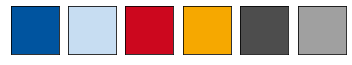

In [3]:
# I could not use the Arial font with the default version of matplotlib
!pip install matplotlib==3.1.1

import matplotlib.pyplot as plt
import matplotlib
matplotlib.__version__

# define color_map
color_map = np.array([[0, 84, 159],       # dark blue
                      #[64, 127, 183],     # dark medium blue
                      [199, 221, 242],    # light blue
                      [204, 7, 30],       # red
                      [246, 168, 0],      # yellow
                      [77, 77, 77],       # dark grey
                      [160, 160, 160]])   # light medium grey
color_map = color_map / 255

ax = plt.figure().subplots(nrows=1, ncols=color_map.shape[0])
for num, c in enumerate(color_map):
    ax[num].imshow([[c]])
    ax[num].get_xaxis().set_ticks([])
    ax[num].get_yaxis().set_ticks([])
plt.show()

In [4]:
# define text style and size

# size for the text
params = {'font.size' : 16,
          'axes.titlesize': 'medium',   # these are relative to font.size
          'axes.labelsize': 'medium',
          'font.weight': 500,
          'axes.titleweight': 'normal',     # these are relative too
          'axes.labelweight': 'normal',
          'font.family' : 'sans-serif',
          'font.sans-serif': 'Arial',
          'legend.fontsize': 12
          }
plt.rcParams.update(params)
fig = plt.figure()

# select the correct size of the plot in advance
a4_breite_cm = 21
seitenraender = 2.5 + 2.5
grafik_scale = 1
width = 11.69 #(a4_breite_cm-seitenraender) * 0.393701
height = 7.5 * 0.393701

fig.set_size_inches(width, height)

# How to save a vector graphics plot

#plt.savefig("../myplot.eps",
#            format="eps",
#            dpi=1000, # recommendation for publication plots
#            bbox_inches='tight', # Plot will be occupy a maximum of available space
#            )

<Figure size 841.68x212.599 with 0 Axes>

# Get data

In [5]:
def read_all(folder, nrows=None):
    """
    Read all .csv files from a directory and return the pandas Dataframes.
    """
    dfs = {}

    for root,dirs,files in os.walk(folder):
        for file in files:
            if file.endswith('.csv'):
                path = os.path.join(root, str(file))
                print('Creating DataFrame from {}'.format(path))
                df = pd.read_csv(path, nrows=nrows)
                dfs[path] = df

    return dfs

In [6]:
# Reduce datacount so to not exceed RAM
nrows = None
path = 'behaviour_mining/data/BipedalWalker-v3/'
dfs = read_all(path, nrows)

Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/ppo2/ppo2_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/ddpg/ddpg_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/sac/sac_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/td3/td3_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/trpo/trpo_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/a2c/a2c_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/acktr/acktr_BipedalWalker-v3.csv


In [7]:
dfs['behaviour_mining/data/BipedalWalker-v3/ppo2/ppo2_BipedalWalker-v3.csv'].head()

,done,rewards,cumulative_reward,obs_0,obs_1,obs_2,obs_3,obs_4,obs_5,obs_6,obs_7,obs_8,obs_9,obs_10,obs_11,obs_12,obs_13,obs_14,obs_15,obs_16,obs_17,obs_18,obs_19,obs_20,obs_21,obs_22,obs_23,action_0,action_1,action_2,action_3
0,0.0,-0.152152,0.000000,-1.553152,0.058755,-2.111050,-0.150687,2.715659,0.936015,0.653329,-1.196846,1.073211,-3.279606,1.274947,-0.284248,-1.137195,1.535426,3.946275,3.969125,3.979726,3.973202,3.942354,3.876772,3.759370,3.565766,1.510411,0.112139,-0.473087,-1.000000,0.267759,-1.000000
1,0.0,-0.116266,-0.152152,-1.476143,0.548042,-2.000170,-0.556585,2.694441,-0.067539,0.361258,-1.196319,-0.931783,-3.029333,1.087949,-0.521497,-1.137885,-0.651285,3.890856,3.913426,3.923912,3.917504,3.887100,3.822428,3.706634,3.515666,1.510411,0.112139,-1.000000,-1.000000,0.271426,-0.428934
2,0.0,-0.155962,-0.268418,-1.393407,0.584033,-1.963198,-0.578523,2.501582,-0.995438,0.164044,-0.819076,-0.931783,-2.879289,0.738007,-0.285848,0.999536,-0.651285,3.832627,3.854902,3.865268,3.858983,3.829043,3.765327,3.651223,3.463026,1.510411,0.112139,-1.000000,-0.224652,1.000000,0.632351
3,0.0,-0.173834,-0.424380,-1.288625,0.738060,-1.942015,-1.047063,2.249776,-1.258509,-0.106864,-1.196320,-0.931783,-2.497924,1.714268,-0.415467,-0.698416,-0.651285,3.730530,3.752289,3.762444,3.756373,3.727250,3.665209,3.554070,3.370729,1.510411,0.112139,-0.879462,-1.000000,0.655143,-0.277381
4,0.0,-0.156413,-0.598214,-1.163460,0.881893,-1.908166,-1.135971,1.999996,-1.258509,-0.379750,-1.186960,-0.931783,-2.496081,0.046901,-0.158971,1.127991,-0.651285,3.621193,3.642399,3.652328,3.646487,3.618237,3.557990,3.450026,3.271887,1.510411,0.112139,-0.330683,-0.005658,-0.428750,0.846328


# Test STS

In [8]:
def get_sts(x, w):
    """Returns subsequence time series."""
    n = len(x)
    sts = []
    for i in range(n-w+1):
        _ = x[i:i+w]
        sts.append(_)
        
    return np.array(sts)

In [9]:
time_series = dfs['behaviour_mining/data/BipedalWalker-v3/ppo2/ppo2_BipedalWalker-v3.csv']['obs_4'][:1000]

## Helper function

In [10]:
def plot_distance_series(distance, labels, time_series, ax, bar_width=1):

    # if no labels list is given
    # if not labels: # possibly change back !!!
    if not np.any(labels):
        labels = [0 for d in distance]
    
    space = range(len(time_series)) # the time series might be longer than the sts array
    # if bar_width is not 1, then sts are not being used -> reposition bars
    if bar_width != 1:
        sts_space = [i*bar_width-bar_width//2 for i in range(len(labels))]
    else:
        sts_space = range(len(labels))

    num_labels = len(set(labels))-1 if -1 in labels else len(set(labels))
    cmap = cm.rainbow(np.linspace(0, 1, num_labels))

    colors = [color_map[label] for label in labels] # [cmap[label] for label in labels]
    for i, c in enumerate(colors):
        if labels[i] == -1:
            colors[i] = color_map[-1] # for noise labels -1 # this color equals light grey
            
    ax.plot(space, time_series, '-', c=color_map[-2], alpha=0.7, label='Time series')
    for ii in range(len(sts_space)):
        ax.bar(sts_space[ii], distance[ii], color=colors[ii], alpha=0.6, width=bar_width)


    
    #if num_labels >= 1:
    #    handles = [, mpatches.Patch(facecolor=color_map[0], edgecolor='#000000', alpha=0.6)]
    #    ax.legend(handles=handles, labels=["Time series", "Distance to NN"], loc="upper right")
    #else:
    #    ax.legend(loc="upper right")

    fig.tight_layout()
    plt.subplots_adjust(right=0.85) #adjust the subplot to the right for the legend
    
    return 

## Using KNN

Plot distance to nearest neighbor.

In [ ]:
%%time 

k = 2

windows = [15, 30, 60]
d_knn = []
l_knn = []

axes = []
for w in windows:
    # create sts data
    sts = get_sts(time_series, w)
    sts_df = pd.DataFrame(sts)
    # drop all subsequences with all zero values.
    sts_df = sts_df[(sts_df != 0).all(axis=1)]
    X = sts_df.values
    print('Created sts with w={}\n-----------------------'.format(w))

    print('\nStarting training on KNN with w={}'.format(w))
    start = time.time()
    neigh = NearestNeighbors(n_neighbors=k, metric='minkowski')
    neigh = neigh.fit(X)
    distances, indices = neigh.kneighbors(X)
    print('Training KNN with w={} took {} sec\n'.format(w, time.time()-start))
    d_knn.append(distances[:, k-1])
    #l_knn.append(neigh.labels_)

Created sts with w=15
-----------------------

Starting training on KNN with w=15
Training KNN with w=15 took 0.007375955581665039 sec

Created sts with w=30
-----------------------

Starting training on KNN with w=30
Training KNN with w=30 took 0.01735520362854004 sec

Created sts with w=60
-----------------------

Starting training on KNN with w=60
Training KNN with w=60 took 0.04465055465698242 sec

CPU times: user 234 ms, sys: 8 ms, total: 242 ms
Wall time: 242 ms


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


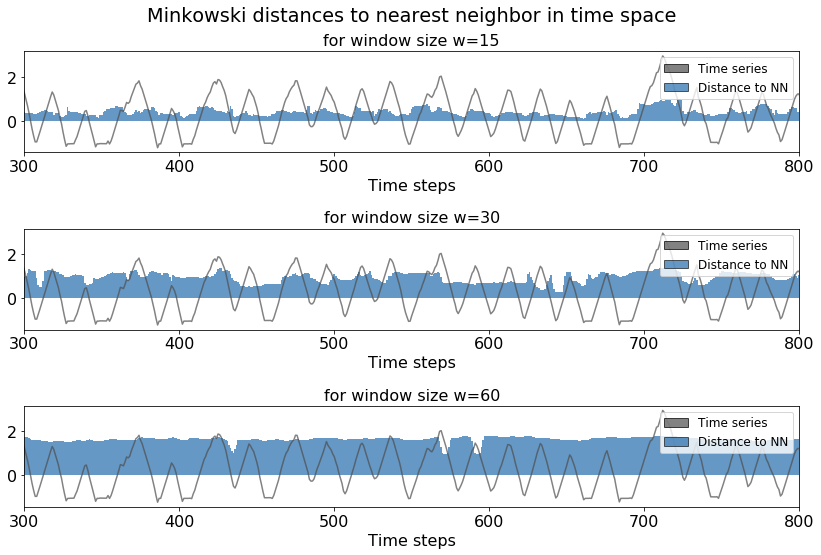

In [ ]:
nwindows = len(windows)
fig, ax = plt.subplots(nrows=nwindows, ncols=1, figsize=(width, 8))

for ii, dist in zip(range(nwindows), d_knn):
    plot_distance_series(dist, None, time_series, ax[ii])
    ax[ii].set_title('for window size w={}'.format(windows[ii]))
    ax[ii].set_xlabel('Time steps')

ax[0].set_xlim(300, 800)
ax[1].set_xlim(300, 800)
ax[2].set_xlim(300, 800)

cols = ['Minkowski distances to nearest neighbor in time space']
pad = 30
for ax_, col in zip(ax, cols):
    ax_.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')#, fontweight='bold', fontsize='large')

# to keep everything in bounds
plt.tight_layout()

fig.savefig("Nearest_neighbor_distances_w_STS.svg", format="svg", dpi=1000)
plt.show()

### With DTW

In [ ]:
%%time 

k = 2

windows = [15, 30, 60]
d_knn = []
l_knn = []

axes = []
for w in windows:
    # create sts data
    sts = get_sts(time_series, w)
    sts_df = pd.DataFrame(sts)
    # drop all subsequences with all zero values.
    sts_df = sts_df[(sts_df != 0).all(axis=1)]
    X = sts_df.values
    print('Created sts with w={}\n-----------------------'.format(w))

    print('\nStarting training on KNN with w={}'.format(w))
    start = time.time()
    neigh = NearestNeighbors(n_neighbors=k, metric=distance_fast)
    neigh = neigh.fit(X)
    distances, indices = neigh.kneighbors(X)
    print('Training KNN with w={} took {} sec\n'.format(w, time.time()-start))
    d_knn.append(distances[:, k-1])
    #l_knn.append(neigh.labels_)

Created sts with w=15
-----------------------

Starting training on KNN with w=15
Training KNN with w=15 took 1.772552490234375 sec

Created sts with w=30
-----------------------

Starting training on KNN with w=30
Training KNN with w=30 took 4.44153904914856 sec

Created sts with w=60
-----------------------

Starting training on KNN with w=60
Training KNN with w=60 took 23.426058053970337 sec

CPU times: user 29.1 s, sys: 731 ms, total: 29.8 s
Wall time: 29.8 s


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


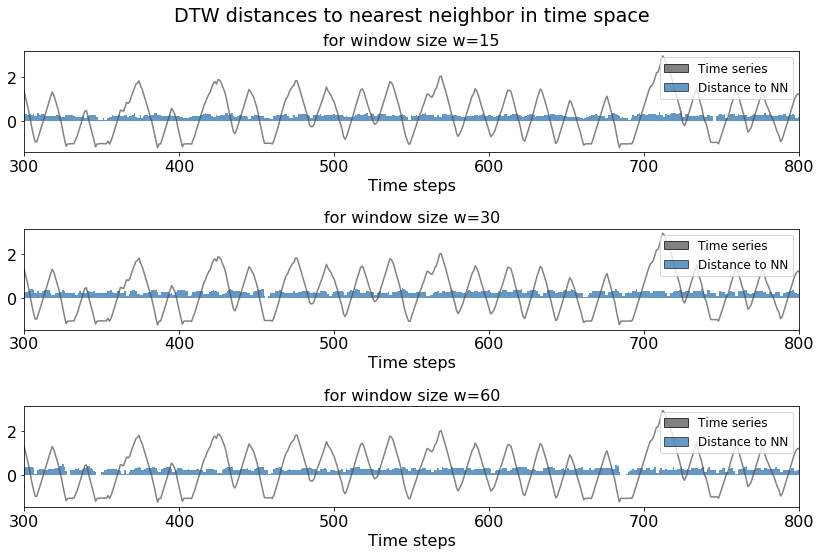

In [ ]:
nwindows = len(windows)
fig, ax = plt.subplots(nrows=nwindows, ncols=1, figsize=(width, 8))

for ii, dist in zip(range(nwindows), d_knn):
    plot_distance_series(dist, None, time_series, ax[ii])
    ax[ii].set_title('for window size w={}'.format(windows[ii]))
    ax[ii].set_xlabel('Time steps')

ax[0].set_xlim(300, 800)
ax[1].set_xlim(300, 800)
ax[2].set_xlim(300, 800)

cols = ['DTW distances to nearest neighbor in time space']
pad = 30
for ax_, col in zip(ax, cols):
    ax_.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')#, fontweight='bold', fontsize='large')

# to keep everything in bounds
plt.tight_layout()

fig.savefig("Nearest_neighbor_distances_w_STS_and_DTW.svg", format="svg", dpi=1000)
plt.show()

## Using OPTICS

Plot reachability distance.

In [11]:
%%time 

windows = [5, 15, 30]

optics_list = []

for w in windows:
    # create sts data
    sts = get_sts(time_series, w)
    sts_df = pd.DataFrame(sts)
    # drop all subsequences with all zero values.
    sts_df = sts_df[(sts_df != 0).all(axis=1)]
    X = sts_df.values
    print('Created sts with w={}\n-----------------------'.format(w))

    print('Starting training on OPTICS with w={}'.format(w))
    start = time.time()
    optics = OPTICS(min_samples=0.1, metric=distance_fast, max_eps=10)
    optics.fit(X)
    optics_list.append(optics)
    print('Training OPTICS with w={} took {} sec\n'.format(w, time.time()-start))

Created sts with w=5
-----------------------
Starting training on OPTICS with w=5
Training OPTICS with w=5 took 5.483718395233154 sec

Created sts with w=15
-----------------------
Starting training on OPTICS with w=15
Training OPTICS with w=15 took 7.818000316619873 sec

Created sts with w=30
-----------------------
Starting training on OPTICS with w=30
Training OPTICS with w=30 took 14.714905977249146 sec

CPU times: user 27 s, sys: 1.22 s, total: 28.2 s
Wall time: 28.3 s


In [12]:
%%time

xi_values = [0.01, 0.01, 0.01]
assert(len(xi_values)==len(optics_list))

labels_xi_list = []
labels_xi_ord_list = []

for optics, xi in zip(optics_list, xi_values):
    labels_xi, clusters_xi = cluster_optics_xi(reachability=optics.reachability_,
                                            predecessor=optics.predecessor_,
                                            ordering=optics.ordering_,
                                            min_samples=optics.min_samples, xi=xi)
    
    labels_xi_list.append(labels_xi)
    labels_xi_ord_list.append(labels_xi[optics.ordering_])

CPU times: user 3.87 ms, sys: 1.96 ms, total: 5.83 ms
Wall time: 6.44 ms


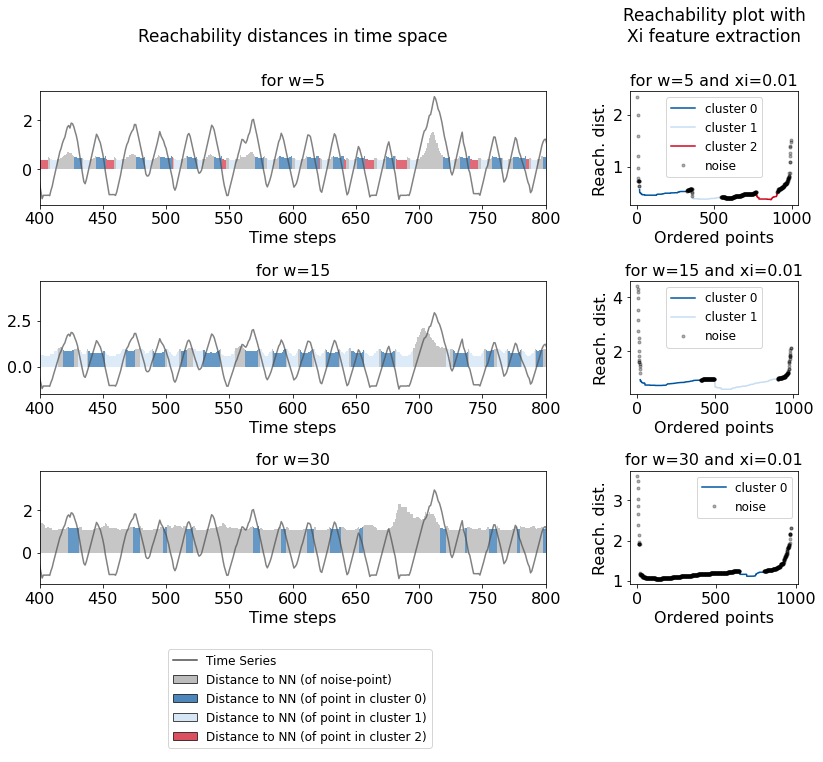

CPU times: user 9.99 s, sys: 129 ms, total: 10.1 s
Wall time: 10 s


In [17]:
%%time

nwindows = len(windows)
fig, ax = plt.subplots(nrows=nwindows, ncols=2, figsize=(width, 11), gridspec_kw={'width_ratios': [3, 1]})


# plot reachability distances in time space
r_optics = [optics.reachability_ for optics in optics_list]
#l_optics = [optics.labels_ for optics in optics_list]
for ii, reachability, labels in zip(range(nwindows), r_optics, labels_xi_list):
    plot_distance_series(reachability, labels, time_series, ax[ii, 0])
    ax[ii, 0].set_title('for w={}'.format(windows[ii]))
    ax[ii, 0].set_xlabel('Time steps')
    #ax[ii, 0].set_ylabel('Time series value')

# plot reachability plots
for ii, optics, labels_xi_ord in zip(range(nwindows), optics_list, labels_xi_ord_list):
    reachability = optics.reachability_[optics.ordering_]
    space = np.array(range(len(labels_xi_ord)))
    num_labels = len(set(labels_xi_ord))-1 if -1 in labels_xi_ord else len(set(labels_xi_ord))
    #colors = cm.rainbow(np.linspace(0, 1, num_labels))

    for klass in range(num_labels):
        color = color_map[klass]
        Xk = space[labels_xi_ord == klass]
        Rk = reachability[labels_xi_ord == klass]
        ax[ii, 1].plot(Xk, Rk, c=color, alpha=1, label='cluster {}'.format(klass))

    ax[ii, 1].plot(space[labels_xi_ord == -1], reachability[labels_xi_ord == -1], 'k.', alpha=0.3, label='noise')
    ax[ii, 1].set_ylabel('Reach. dist.')
    ax[ii, 1].set_xlabel('Ordered points')
    ax[ii, 1].set_title('for w={} and xi={}'.format(windows[ii], xi_values[ii]))

    ax[ii, 1].legend();

# clean up plots
#ax[0, 1].set_ylim(0.5, 1.5)
#ax[1, 1].set_ylim(0.5, 2)
#ax[2, 1].set_ylim(0.5, 2.5)
#ax[3, 1].set_ylim(1, 2.5)

ax[0, 0].set_xlim(400, 800)
ax[1, 0].set_xlim(400, 800)
ax[2, 0].set_xlim(400, 800)

# create space between subplots
fig.tight_layout(rect=[0,0.16,1,0.9])

# make legend
from matplotlib.lines import Line2D
time_series_line = Line2D([0], [0], color=color_map[-2], linewidth=1.5, linestyle='-')
dist_1 = mpatches.Patch(facecolor=color_map[-1], edgecolor='#000000', alpha=0.7)
dist_2 = mpatches.Patch(facecolor=color_map[0], edgecolor='#000000', alpha=0.7)
dist_3 = mpatches.Patch(facecolor=color_map[1], edgecolor='#000000', alpha=0.7)
dist_4 = mpatches.Patch(facecolor=color_map[2], edgecolor='#000000', alpha=0.7)
dist_5 = mpatches.Patch(facecolor=color_map[2], edgecolor='#000000', alpha=0.7)

handles = [time_series_line, dist_1, dist_2, dist_3, dist_4, dist_5][:5]
labels = ['Time Series', "Distance to NN (of noise-point)", "Distance to NN (of point in cluster 0)", "Distance to NN (of point in cluster 1)", "Distance to NN (of point in cluster 2)", "Distance to NN (of point in cluster 3)"][:5]
lgd = fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0.52, 0.15))

cols = ['Reachability distances in time space', 'Reachability plot with\nXi feature extraction']
pad = 50
for ax_, col in zip(ax[0], cols):
    ax_.annotate(col, xy=(0.5, 1), xytext=(0, pad), 
                xycoords='axes fraction', textcoords='offset points',
                size=17, ha='center', va='baseline')#, fontweight='bold', fontsize='large')

#fig.tight_layout()
fig.savefig("Reachability_distances_w_STS.svg", format="svg", dpi=1000)#, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Test consecutive windows

In [18]:
def get_csts(x, w):
    """Returns consecutive subsequence time series."""
    n = len(x)
    csts = []
    for i in range(n):
        if i%w==0 and i+w<=n-1:
            _ = x[i:i+w]
            csts.append(_)
            
    return np.array(csts)

In [19]:
time_series = dfs['behaviour_mining/data/BipedalWalker-v3/ppo2/ppo2_BipedalWalker-v3.csv']['obs_4'][:10000]

## Using KNN

In [ ]:
%%time 

k = 2

windows = [15, 30, 60]
d_knn = []
l_knn = []

axes = []
for w in windows:
    # create sts data
    sts = get_csts(time_series, w)
    sts_df = pd.DataFrame(sts)
    # drop all subsequences with all zero values.
    sts_df = sts_df[(sts_df != 0).all(axis=1)]
    X = sts_df.values
    print('Created sts with w={}\n-----------------------'.format(w))

    print('\nStarting training on KNN with w={}'.format(w))
    start = time.time()
    neigh = NearestNeighbors(n_neighbors=k, metric="minkowski")
    neigh = neigh.fit(X)
    distances, indices = neigh.kneighbors(X)
    print('Training KNN with w={} took {} sec\n'.format(w, time.time()-start))
    d_knn.append(distances[:, k-1])
    #l_knn.append(neigh.labels_)

Created sts with w=15
-----------------------

Starting training on KNN with w=15
Training KNN with w=15 took 0.004577159881591797 sec

Created sts with w=30
-----------------------

Starting training on KNN with w=30
Training KNN with w=30 took 0.004866123199462891 sec

Created sts with w=60
-----------------------

Starting training on KNN with w=60
Training KNN with w=60 took 0.004144906997680664 sec

CPU times: user 98.2 ms, sys: 938 µs, total: 99.2 ms
Wall time: 109 ms


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


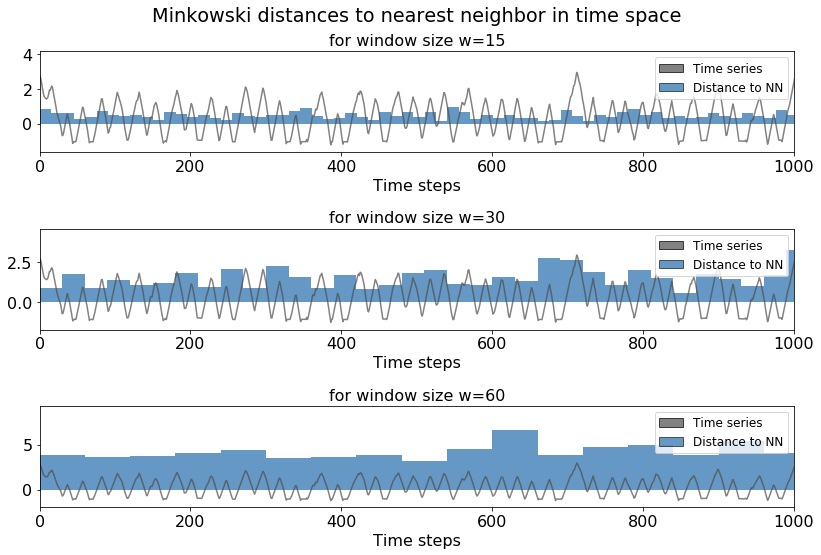

In [ ]:
nwindows = len(windows)
fig, ax = plt.subplots(nrows=nwindows, ncols=1, figsize=(width, 8))

for ii, dist in zip(range(nwindows), d_knn):
    plot_distance_series(dist, None, time_series, ax[ii], bar_width=windows[ii])
    ax[ii].set_title('for window size w={}'.format(windows[ii]))
    ax[ii].set_xlabel('Time steps')
    #ax[ii].set_ylabel('Time series value')


ax[0].set_xlim(0, 1000)
ax[1].set_xlim(0, 1000)
ax[2].set_xlim(0, 1000)

cols = ['Minkowski distances to nearest neighbor in time space']
pad = 30
for ax_, col in zip(ax, cols):
    ax_.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')#, fontweight='bold', fontsize='large')

# to keep everything in bounds
plt.tight_layout()

fig.savefig("Nearest_neighbor_distances_w_CSTS.svg", format="svg", dpi=1000)
plt.show()

### with DTW

In [ ]:
%%time 

k = 2

windows = [15, 30, 60]
d_knn = []
l_knn = []

axes = []
for w in windows:
    # create sts data
    sts = get_csts(time_series, w)
    sts_df = pd.DataFrame(sts)
    # drop all subsequences with all zero values.
    sts_df = sts_df[(sts_df != 0).all(axis=1)]
    X = sts_df.values
    print('Created sts with w={}\n-----------------------'.format(w))

    print('\nStarting training on KNN with w={}'.format(w))
    start = time.time()
    neigh = NearestNeighbors(n_neighbors=k, metric=distance_fast)
    neigh = neigh.fit(X)
    distances, indices = neigh.kneighbors(X)
    print('Training KNN with w={} took {} sec\n'.format(w, time.time()-start))
    d_knn.append(distances[:, k-1])
    #l_knn.append(neigh.labels_)

Created sts with w=15
-----------------------

Starting training on KNN with w=15
Training KNN with w=15 took 1.2825932502746582 sec

Created sts with w=30
-----------------------

Starting training on KNN with w=30
Training KNN with w=30 took 1.0495529174804688 sec

Created sts with w=60
-----------------------

Starting training on KNN with w=60
Training KNN with w=60 took 0.9816732406616211 sec

CPU times: user 3.26 s, sys: 211 ms, total: 3.47 s
Wall time: 3.4 s


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


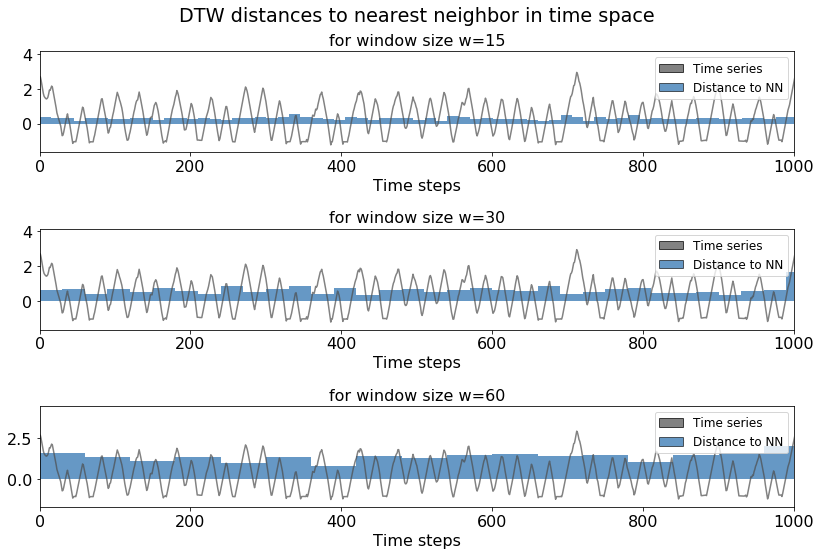

In [ ]:
nwindows = len(windows)
fig, ax = plt.subplots(nrows=nwindows, ncols=1, figsize=(width, 8))

for ii, dist in zip(range(nwindows), d_knn):
    plot_distance_series(dist, None, time_series, ax[ii], bar_width=windows[ii])
    ax[ii].set_title('for window size w={}'.format(windows[ii]))
    ax[ii].set_xlabel('Time steps')
    #ax[ii].set_ylabel('Time series value')


ax[0].set_xlim(0, 1000)
ax[1].set_xlim(0, 1000)
ax[2].set_xlim(0, 1000)

cols = ['DTW distances to nearest neighbor in time space']
pad = 30
for ax_, col in zip(ax, cols):
    ax_.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')#, fontweight='bold', fontsize='large')

# to keep everything in bounds
plt.tight_layout()

fig.savefig("Nearest_neighbor_distances_w_CSTS_DTW.svg", format="svg", dpi=1000)
plt.show()

## Using OPTICS

In [20]:
%%time 

windows = [5, 15, 30]

optics_list = []

for w in windows:
    # create sts data
    csts = get_csts(time_series, w)
    csts_df = pd.DataFrame(csts)
    # drop all subsequences with all zero values.
    csts_df = csts_df[(csts_df != 0).all(axis=1)]
    X = csts_df.values
    print('Created sts with w={}\n-----------------------'.format(w))

    print('Starting training on OPTICS with w={}'.format(w))
    start = time.time()
    optics = OPTICS(min_samples=0.1, metric=distance_fast, max_eps=10)
    optics.fit(X)
    optics_list.append(optics)
    print('Training OPTICS with w={} took {} sec\n'.format(w, time.time()-start))

Created sts with w=5
-----------------------
Starting training on OPTICS with w=5
Training OPTICS with w=5 took 22.685112714767456 sec

Created sts with w=15
-----------------------
Starting training on OPTICS with w=15
Training OPTICS with w=15 took 4.384869337081909 sec

Created sts with w=30
-----------------------
Starting training on OPTICS with w=30
Training OPTICS with w=30 took 2.657561779022217 sec

CPU times: user 28.2 s, sys: 1.73 s, total: 29.9 s
Wall time: 29.9 s


In [21]:
%%time

xi_values = [0.001, 0.001, 0.001]
assert(len(xi_values)==len(optics_list))

labels_xi_list = []
labels_xi_ord_list = []

for optics, xi in zip(optics_list, xi_values):
    labels_xi, clusters_xi = cluster_optics_xi(reachability=optics.reachability_,
                                            predecessor=optics.predecessor_,
                                            ordering=optics.ordering_,
                                            min_samples=optics.min_samples, xi=xi)
    
    labels_xi_list.append(labels_xi)
    labels_xi_ord_list.append(labels_xi[optics.ordering_])

CPU times: user 9.48 ms, sys: 0 ns, total: 9.48 ms
Wall time: 9.64 ms


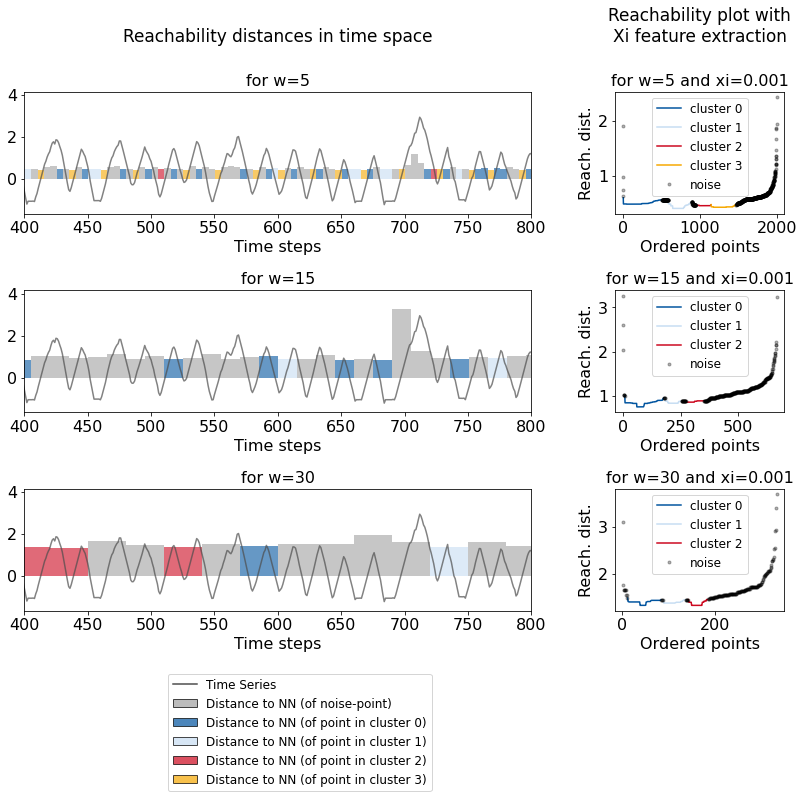

CPU times: user 10.3 s, sys: 136 ms, total: 10.4 s
Wall time: 10.3 s


In [22]:
%%time

nwindows = len(windows)
fig, ax = plt.subplots(nrows=nwindows, ncols=2, figsize=(width, 11.5), gridspec_kw={'width_ratios': [3, 1]})

# plot reachability distances in time space
r_optics = [optics.reachability_ for optics in optics_list]
#l_optics = [optics.labels_ for optics in optics_list]

for ii, reachability, labels in zip(range(nwindows), r_optics, labels_xi_list):
    plot_distance_series(reachability, labels, time_series, ax[ii, 0], bar_width=windows[ii])
    ax[ii, 0].set_title('for w={}'.format(windows[ii]))
    ax[ii, 0].set_xlabel('Time steps')
    #ax[ii, 0].set_ylabel('Time series value')

# plot reachability plots
for ii, optics, labels_xi_ord in zip(range(nwindows), optics_list, labels_xi_ord_list):
    reachability = optics.reachability_[optics.ordering_]
    space = np.array(range(len(labels_xi_ord)))
    num_labels = len(set(labels_xi_ord))-1 if -1 in labels_xi_ord else len(set(labels_xi_ord))
    #colors = cm.rainbow(np.linspace(0, 1, num_labels))

    for klass in range(num_labels):
        color = color_map[klass]
        Xk = space[labels_xi_ord == klass]
        Rk = reachability[labels_xi_ord == klass]
        ax[ii, 1].plot(Xk, Rk, c=color, alpha=1, label='cluster {}'.format(klass))

    ax[ii, 1].plot(space[labels_xi_ord == -1], reachability[labels_xi_ord == -1], 'k.', alpha=0.3, label='noise')
    ax[ii, 1].set_ylabel('Reach. dist.')
    ax[ii, 1].set_xlabel('Ordered points')
    ax[ii, 1].set_title('for w={} and xi={}'.format(windows[ii], xi_values[ii]))

    ax[ii, 1].legend();

# clean up plots
#ax[0, 1].set_ylim(0.5, 1.5)
#ax[1, 1].set_ylim(0.5, 2)
#ax[2, 1].set_ylim(0.5, 2.5)
#ax[3, 1].set_ylim(1, 2.5)

ax[0, 0].set_xlim(400, 800)
ax[1, 0].set_xlim(400, 800)
ax[2, 0].set_xlim(400, 800)

# create space between subplots
fig.tight_layout(rect=[0,0.16,1,0.9])

# make legend
from matplotlib.lines import Line2D
time_series_line = Line2D([0], [0], color=color_map[-2], linewidth=1.5, linestyle='-')
dist_1 = mpatches.Patch(facecolor=color_map[-1], edgecolor='#000000', alpha=0.7)
dist_2 = mpatches.Patch(facecolor=color_map[0], edgecolor='#000000', alpha=0.7)
dist_3 = mpatches.Patch(facecolor=color_map[1], edgecolor='#000000', alpha=0.7)
dist_4 = mpatches.Patch(facecolor=color_map[2], edgecolor='#000000', alpha=0.7)
dist_5 = mpatches.Patch(facecolor=color_map[3], edgecolor='#000000', alpha=0.7)

handles = [time_series_line, dist_1, dist_2, dist_3, dist_4, dist_5][:6]
labels = ['Time Series', "Distance to NN (of noise-point)", "Distance to NN (of point in cluster 0)", "Distance to NN (of point in cluster 1)", "Distance to NN (of point in cluster 2)", "Distance to NN (of point in cluster 3)"][:6]
lgd = fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0.52, 0.16))

cols = ['Reachability distances in time space', 'Reachability plot with\nXi feature extraction']
pad = 50
for ax_, col in zip(ax[0], cols):
    ax_.annotate(col, xy=(0.5, 1), xytext=(0, pad), 
                xycoords='axes fraction', textcoords='offset points',
                size=17, ha='center', va='baseline')#, fontweight='bold', fontsize='large')  

# create space between subplots
#fig.tight_layout()

#fig.tight_layout()
fig.savefig("Reachability_distances_w_CSTS.svg", format="svg", dpi=1000)
plt.show()